# Ingest and process data

This notebook loads the data that was stored on Box, and converts it to dataframe and dataset with a common format across all collections.

It provides functionality for downlaoding images.

In [192]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
import chromadb

In [194]:
from tools.weaving_tools import NMSCollection, SMGCollection, BTCollection, VACollection
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [195]:
nms = NMSCollection(device='mps',img_folder='nms_imgs')
nms.load_original_csvs(files=list(Path('data').glob('NMS_*.*')))
nms.save_csv('data/NMS.csv')

In [196]:
smg = SMGCollection(device='mps', img_folder='smg_imgs')
smg.load_from_json('data/smg_objects_06_06_2022.json')
smg.save_csv('data/SMG.csv')

0it [00:00, ?it/s]

In [6]:
bt = BTCollection(device='mps', img_folder='bt_imgs')
bt.load_from_xml('data/bt_catalogue.xml')
bt.save_csv('data/BT.csv')

  0%|          | 0/58733 [00:00<?, ?it/s]

In [7]:
va = VACollection(device='mps', img_folder='va_imgs')
va.load_from_csv('data/VA.csv')

# Download images

In [199]:
collection = SMGCollection(img_folder=Path('smg_imgs'))
collection.load_from_csv('data/SMG.csv')
collection.fetch_images(n=10)
#collection.save_csv('data/SMG.csv')

before downloading 50287
remaining images to download 98842


  0%|          | 0/10 [00:00<?, ?it/s]

after downloading 50287


In [200]:
# download images by category
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications','Photography','Photographic Technology']#df_comms = smg_img_overview[smg_img_overview.apply(lambda x: 'commun' in x.category.lower(), axis=1)] 
comms = smg_img_overview[smg_img_overview.category.isin(categories)]
print(comms.shape)
#comms = smg_img_overview[smg_img_overview.apply(lambda x: 'commun' in x.category.lower(), axis=1)]
#collection.fetch_images(urls=comms.img_url.to_list())
record_ids = set(comms.record_url.apply(lambda x: x.split('/')[-1]))
collection.fetch_images(record_ids=record_ids)

(4940, 6)
before downloading 50287
[]


0it [00:00, ?it/s]

after downloading 50287


In [201]:
collection = BTCollection(img_folder=Path('bt_imgs'))
collection.load_from_csv('data/BT.csv')
collection.fetch_images(n=5)

before downloading 1449


  0%|          | 0/5 [00:00<?, ?it/s]

after downloading 1460


In [202]:
collection = NMSCollection(img_folder=Path('nms_imgs'))
collection.load_from_csv('data/NMS.csv')
collection.fetch_images(n=5)

  0%|          | 0/1631 [00:00<?, ?it/s]

In [108]:
# download images from excel
# image_overview = pd.read_excel('data/NMS image info.xlsx',sheet_name='Sheet1')
# ids = image_overview['media.reference'].to_list()
# collection.fetch_images()
# collection.fetch_images(imgs_ids=ids)

## add URLs

In [203]:
base_url = 'https://framemark.vam.ac.uk/collections/'
postfix = '/full/600,/0/default.jpg'
va.df['img_url'] = va.df.apply(lambda x: f'{base_url}{x.img_loc}{postfix}', axis=1)

In [204]:
va.df['img_url'].iloc[0] 

'https://framemark.vam.ac.uk/collections/2021MW2149/full/600,/0/default.jpg'

In [205]:
smg.df['base_url'] = 'https://coimages.sciencemuseumgroup.org.uk/images/'
smg.df['img_url'] = smg.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)

In [206]:
smg.df['img_url'].iloc[0] 

'https://coimages.sciencemuseumgroup.org.uk/images/'

In [207]:
nms.df['base_url'] = 'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value='
nms.df['img_url'] = nms.df.apply(lambda x: f'{x.base_url}{x.img_loc}'.strip(), axis=1)

In [208]:
nms.df['img_url'].iloc[0] 

'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value=PF53187'

In [209]:
bt.df['base_url'] = 'http://www.digitalarchives.bt.com/CalmView/GetImage.ashx?db=Catalog&type=default&fname='
bt.df['img_url'] = bt.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)

In [210]:
bt.df['img_url'].iloc[0] 

'http://www.digitalarchives.bt.com/CalmView/GetImage.ashx?db=Catalog&type=default&fname='

# Filter communications data

In [212]:
# open the spreadsheet with image lookup
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
# select the categories we want to include in the communications collections
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications','Photography','Photographic Technology']
#df_comms = smg_img_overview[smg_img_overview.apply(lambda x: 'commun' in x.category.lower(), axis=1)] 
# select objects from based on these categories
df_comms = smg_img_overview[smg_img_overview.category.isin(categories)]
# get object ids for communication object
object_ids = df_comms.record_url.apply(lambda x: x.split('/')[-1])
smg.df.img_path = smg.df.img_path.apply(lambda x: Path(x)) 
smg.df = smg.df[smg.df.record_id.isin(object_ids)]
smg.df = smg.df[smg.df.img_path.apply(lambda x: x.is_file() and not x.is_dir())].reset_index(drop=True)
smg.df.shape,df_comms.shape

((4675, 10), (4940, 6))

In [213]:
image_overview = pd.read_csv('data/NMS_comms_image_info.csv')
ojbect_ids = image_overview['object_number'].to_list()
nms.df = nms.df[nms.df.record_id.isin(ojbect_ids)].reset_index(drop=True)
nms.df.downloaded = True

# Create Vector Database

In [217]:
collection_df = pd.concat([smg.df,nms.df],axis=0)
collection_df.shape

(6020, 10)

In [218]:
collection_df.head()

,record_id,name,description,taxonomy,img_loc,img_name,img_path,downloaded,base_url,img_url
0,co8413501,Broadcast cartridge used by Radio Manchester t...,Broadcast cartridge used by Radio Manchester t...,audio tape; sound recording; <information arte...,204/255/medium_cd0620_049_100527_2005_86_35_Pr...,204|255|medium_cd0620_049_100527_2005_86_35_Pr...,smg_imgs/204|255|medium_cd0620_049_100527_2005...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
1,co8409836,RadioSpares Preset radio component,RadioSpares Preset radio component,,209/376/medium_cd0472_015_081216_1996_10_507_F...,209|376|medium_cd0472_015_081216_1996_10_507_F...,smg_imgs/209|376|medium_cd0472_015_081216_1996...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
2,co8409837,RadioSpares Preset radio component,RadioSpares Preset radio component,,209/377/medium_cd0472_016_081216_1996_10_508_F...,209|377|medium_cd0472_016_081216_1996_10_508_F...,smg_imgs/209|377|medium_cd0472_016_081216_1996...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
3,co8417687,Mercury tube switch,Mercury tube switch,,126/903/medium_cd0701_033_121212_2003_22_120_8...,126|903|medium_cd0701_033_121212_2003_22_120_8...,smg_imgs/126|903|medium_cd0701_033_121212_2003...,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...
4,co8419534,Thermionic triode valve,Thermionic triode valve,electrical component; component parts; <object...,475/202/medium_SMG00243587.jpg,475|202|medium_SMG00243587.jpg,smg_imgs/475|202|medium_SMG00243587.jpg,True,https://coimages.sciencemuseumgroup.org.uk/ima...,https://coimages.sciencemuseumgroup.org.uk/ima...


In [219]:
collection_df = collection_df[~collection_df.img_path.apply(lambda x: Path(x).is_dir())]
collection_df.shape

(6020, 10)

In [220]:
collection_df.to_csv('data/communications_data.csv')

In [241]:
import chromadb
import json
from weavingtools.embedding_tools import SigLIPEmbedder, reshape_image_batch,reshape_text_batch, batchify
from weavingtools.weaving_tools import plot_query_results

In [222]:
checkpoint = 'google/siglip-base-patch16-224'
siglip_embedder = SigLIPEmbedder(checkpoint)

In [223]:
client = chromadb.PersistentClient(path="ce_comms_db")

In [224]:
try:
    client.delete_collection(name="ce_comms_db")
except Exception as e:
    print(e)

In [225]:
from chromadb.utils.data_loaders import ImageLoader
data_loader = ImageLoader()

In [226]:
collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                            embedding_function=siglip_embedder, 
                                            data_loader=data_loader
                                            )

In [242]:
collection = nms # smg | nms
collection.df.downloaded = True

In [243]:
image_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_url','img_path',]].values.tolist())
text_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_url','img_path',]].values.tolist())
#keyword_batches = batchify(collection.df[collection.df.downloaded==True][['record_id','name','description','img_url','img_path',]].values.tolist())

In [244]:
#reshape_image_batch(next(image_batches), collection.collection_name)
#reshape_text_batch(next(text_batches), collection.collection_name)
#reshape_keyword_batch(next(text_batches), collection.collection_name)

In [245]:
#next(image_batches)

In [246]:
collection_db.count()

19349

In [247]:
for b in tqdm(image_batches):
    content, metadatas = reshape_image_batch(b,collection.collection_name)
    counter = collection_db.count()
    ids = [str(i) for i in range(counter,counter+len(content))]
    collection_db.add(
        ids = ids,
        uris = content,
        metadatas = metadatas
    )

0it [00:00, ?it/s]

In [248]:
for b in tqdm(text_batches):
    content, metadatas = reshape_text_batch(b, collection.collection_name)
    counter = collection_db.count()
    ids = [str(i) for i in range(counter,counter+len(content))]
    collection_db.add(
        ids = ids,
        documents = content,
        metadatas = metadatas
    )

0it [00:00, ?it/s]

In [213]:
# for b in tqdm(keyword_batches):
#     content, metadatas = reshape_keyword_batch(b, collection.collection_name)
#     counter = collection_db.count()
#     ids = [str(i) for i in range(counter,counter+len(content))]
#     collection_db.add(
#         ids = ids,
#         documents = content,
#         metadatas = metadatas
#     )

0it [00:00, ?it/s]

In [214]:
collection_db.count()

37219

Small car aerial for transportable mobile telephone, made by Vodafone Limited, England, 1985; Small car aerial for transportable mobile telephone, made by Vodafone Limited, England, 1985 The Mobira Transportable, was launched by Vodafone in 1985, the year that the first UK mobile networks, Vodafone and Cellnet, were launched. Early mobile phones like these were normally installed in cars, rather than carried by the user.


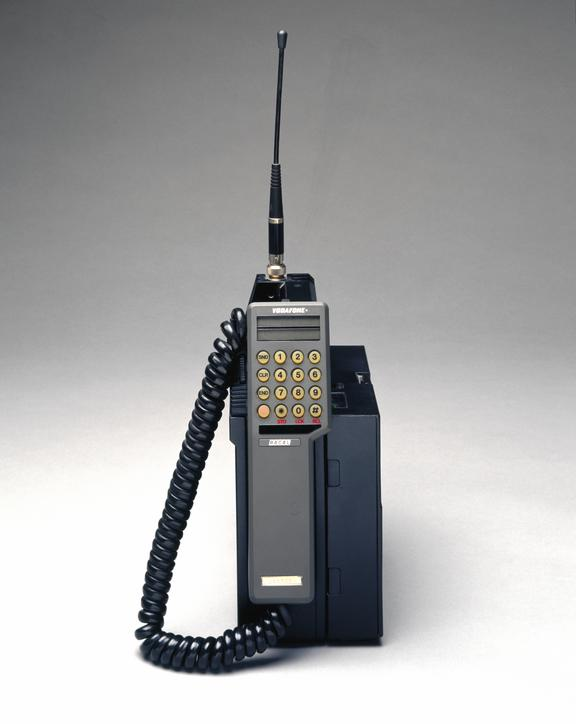

In [249]:

idx = 532
query_img = smg.df[smg.df.downloaded==True].img_path.iloc[idx]
print(smg.df[smg.df.downloaded==True].description.iloc[idx])
Image.open(query_img)

(5132, 8)

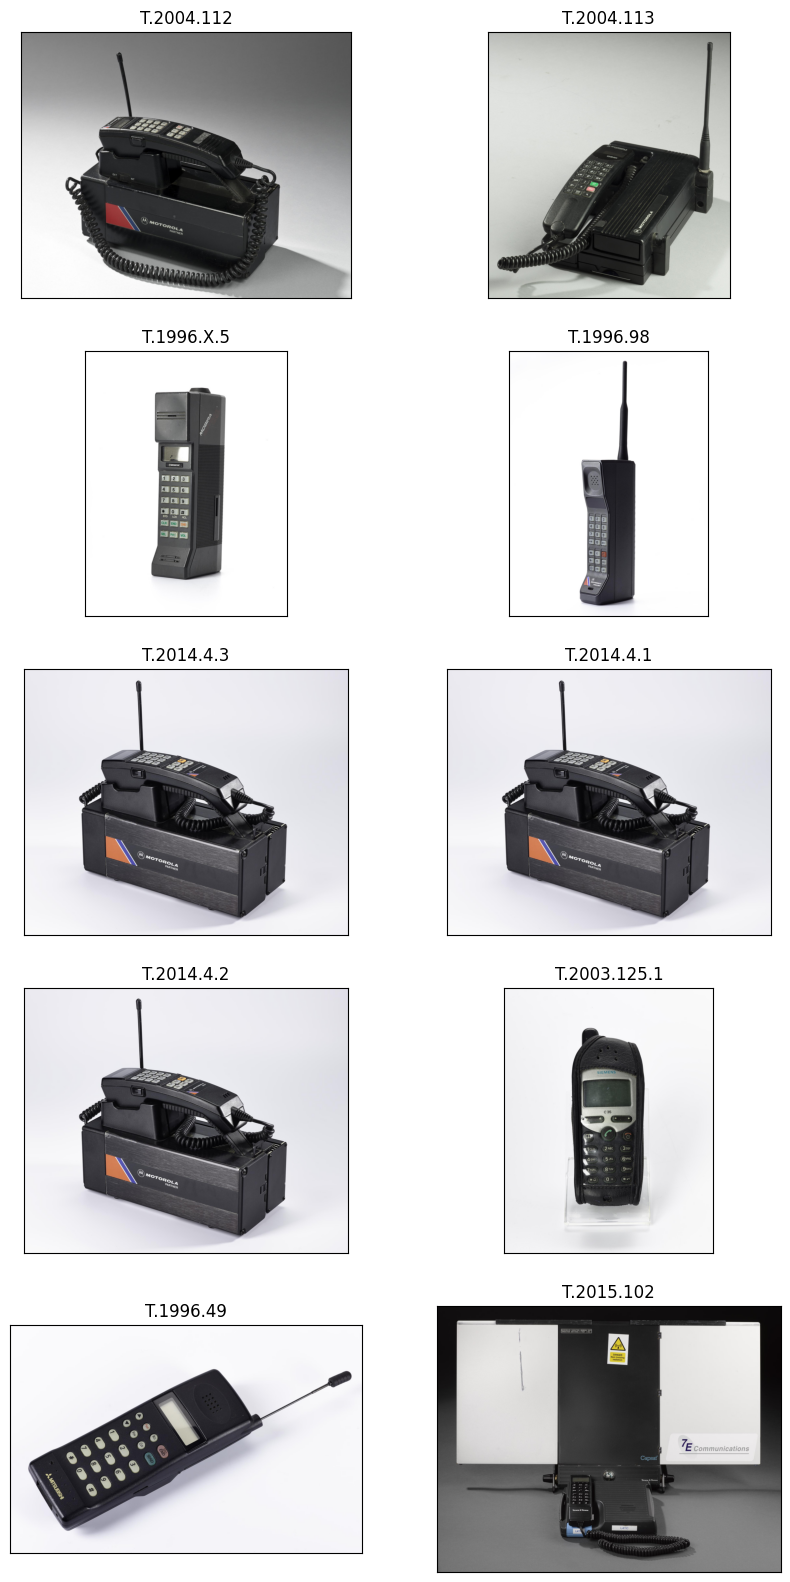

In [250]:
filters = {
    "$and": [
        {
            "input_modality": {
                "$eq": "text"
            }
        },
        {
            "collection": {
                "$eq" : "nms"
            }
        }
    ]
}

results = collection_db.query(query_uris=[query_img],where=filters, n_results=25)
query_df = plot_query_results(results, collection_df)

In [121]:
query_df.description

0     One of a group of specimens of telephone appar...
1     Complete telephone made by William Holms, Pais...
2     Telephone of wood and metal, with diaphragm an...
3     Gecophone loudspeaker in black vulcanite, earl...
4     Bell type telephone earpiece in vulcanite by t...
5     Gramophone pick-up attachment, Gecophone B.C. ...
6     Impulse dial for automatic telephone equipment...
7     Impulse dial for automatic telephone equipment...
8     One of four items of telephone speaking clock ...
9     One of four items of telephone speaking clock ...
10    Telephone earpiece, 'pony crown', by George M....
11    Loudspeaking telephone (loudspeaker) made by S...
12    Desk telephone, a hand generating magneto unit...
13    HMV portable gramophone, model 102, Serial No....
14    Ericsson telephone, with the handset incorpora...
15    Ericsson telephone, with the handset hooked on...
16    Desktop telephone type 328 of red bakelite, wi...
17    Brass-cased candlestick telephone attached

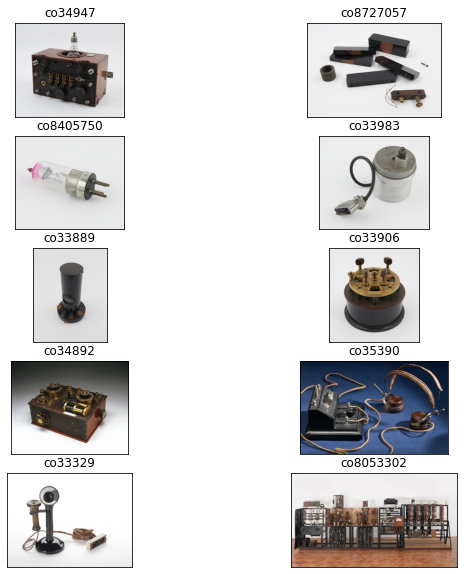

In [108]:
filters = {
    "$and": [
        {
            "input_modality": {
                "$eq": "text"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}


results = collection_db.query(
                query_texts=[
                        """BTH valve, type A.T.26, serial No. 575, (RMW/J89 - McVitie Weston number), by British Thomson-Houston Company Limited."""
                    ],
                where=filters,n_results=100
        )
query_df = plot_query_results(results, collection_df)

In [110]:
query_df.description.values[:10]

array(["Tuner Aircraft Valve Mk. 1 marked 'Tuner Aircraft No 9,' also known as one of the earliest valve tuner for aircraft, first made in 1916. Very few were made - possibly as few as around 100 - with all sets made at the War Department Wireless Telegraphy factory at Teddington, Middlesex. This particular set is a very early example as indicated by 'no. 9' and is also inscribed 'W/T factory W.D. Teddington S.W.'",
       "Fixings, for large main jigger (oscillation transformer) in wood case (No. 72260), made by Marconi's Wireless Telegraph Company Limited, Chelmsford, Essex, England, 1900-1950",
       'Thermionic valve, triode, manufactured by A. C. Cossor Ltd, 1924, A26; Type no. PL; red capped',
       'Hysteresis motor type D-997-A, no. 485238, developed for facsimile machines by Muirhead and Co. Ltd.',
       "D'Arsonval Galvanometer no. 151668, by Muirhead and Co. Ltd., December, 1947",
       'Microfarad condenser no. 1013 by Latimer Clark, Muirhead and Co. Ltd., made for the 

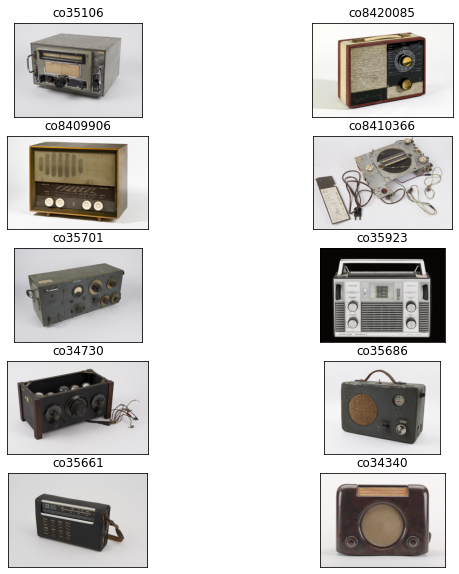

In [127]:

results = collection_db.query(query_texts=["radio"],
                             where={"input_modality": "image"},n_results=100)

query_df = plot_query_results(results, collection_df)

In [116]:
query_df.description.values[:10]

array(['Telephone handset, two-tone light brown and black, push button, Model 76E Digital 2000, made by Standard Electric Kirk, Denmark, 1982',
       'Telephone handset, black, dial, model K500, made by ITT Telecommunications, USA, 1973',
       "Technophone EXCELL PC105T mobile telephone, manufactured by Technophone Limited, Camberley, Surrey, England, 1986.; Technophone EXCELL PC105T mobile telephone, manufactured by Technophone Limited, Camberley, Surrey, England, 1986. Released in 1986 and marketed as the first phone to fit in a shirt pocket, the EXCELL PC105T was the brainchild of Nils Martensson a former employee of mobile technology giant Sony Ericsson. The phone was developed with a grant from the UK's Department for Trade and Industry, and its small size inspired government policy makers to see the mass-market potential of mobiles, even though at £1990 when first sold it was far too expensive for most people to be able to own a phone like this.",
       'Aluminium finial for 

## Fin.